In [15]:
import Pkg
Pkg.add("DifferentialEquations")
Pkg.add("Turing")
Pkg.add("Distributions")
Pkg.add("StatsPlots")
Pkg.add("Plots")
Pkg.add("MCMCChains")

  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
  [c7f686f2] + MCMCChains v3.0.6
   Updating `~/.julia/environments/v

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260


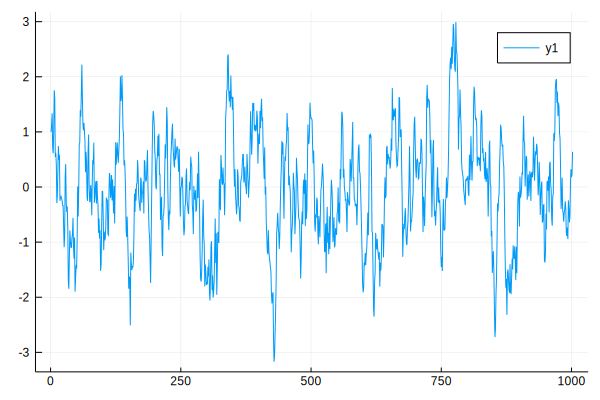

In [12]:
using DifferentialEquations
using Plots

μ = 0.0
σ = sqrt(2)
Θ = 1.0
W = OrnsteinUhlenbeckProcess(Θ,μ,σ,0.0,1.0)
prob = NoiseProblem(W,(0.0,100.0))
sol = solve(prob;dt=0.1)
plot(sol.u)

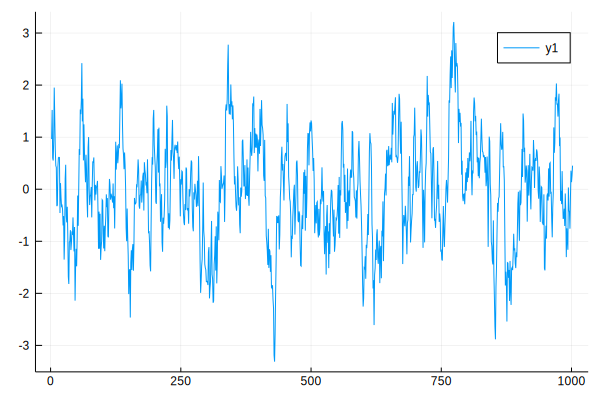

In [13]:
using Distributions, Random
ou_data = sol.u
noise = rand(Normal(0,0.2), length(ou_data))
plot(ou_data.+noise)

In [16]:
using Turing
using Distributions
using LinearAlgebra
using MCMCChains

# Ornstein-Uhlenbeck process with added Gaussian noise
@model oupn(rn,T,delta_t,::Type{R}=Vector{Float64}) where {R} = begin
    ampl ~ Uniform(0.0,5.0)
    tau ~ Uniform(0.0,5.0)
    noise_ampl ~ Uniform(0.0,1)
    
    b = exp(-delta_t/tau)
    r = R(undef, T)
    
    r[1] ~ Normal(0,sqrt(ampl))
    
    for i=2:T
        r[i] ~ Normal(r[i-1]*b,sqrt(ampl*(1-b^2)))
    end
    rn ~ MvNormal(r,sqrt(ampl))
end

┌ Info: Precompiling Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0]
└ @ Base loading.jl:1260
ERROR: LoadError: LoadError: UndefVarError: AbstractChains not defined
Stacktrace:
 [1] include(::Module, ::String) at ./Base.jl:377
 [2] include(::String) at /Users/hstrey/.julia/packages/Turing/xFzfF/src/Turing.jl:1
 [3] top-level scope at /Users/hstrey/.julia/packages/Turing/xFzfF/src/Turing.jl:124
 [4] include(::Module, ::String) at ./Base.jl:377
 [5] top-level scope at none:2
 [6] eval at ./boot.jl:331 [inlined]
 [7] eval(::Expr) at ./client.jl:449
 [8] top-level scope at ./none:3
in expression starting at /Users/hstrey/.julia/packages/Turing/xFzfF/src/utilities/Utilities.jl:6
in expression starting at /Users/hstrey/.julia/packages/Turing/xFzfF/src/Turing.jl:124


ErrorException: Failed to precompile Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0] to /Users/hstrey/.julia/compiled/v1.4/Turing/gm4QC_8bdJ6.ji.

In [5]:
using StatsPlots

chn = sample(oupn(ou_data.+noise,length(ou_data),0.1), NUTS(0.65), 2000)

# Summarise results (currently requires the master branch from MCMCChains)
describe(chn)



┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1260
ERROR: ERROR: ERROR: ERROR: LoadError: LoadError: LoadError: LoadError: ERROR: LoadError: LoadError: InterruptException:
Stacktrace:InterruptException:
Stacktrace:InterruptException:
Stacktrace:InterruptException:
Stacktrace:
 [1] 
 [1] 
 [1] poptaskrefpoptaskrefgrow_to!
 [1] (poptaskref((::(::::Base.InvasiveLinkedListSynchronized{Task}) at ./task.jl:702
 [2] wait() at ./task.jl:709
 [3] wait(::Base.GenericCondition{Base.Threads.SpinLock}) at ./condition.jl:106
 [4] wait(::Base.Process) at ./process.jl:622
 [5] success at ./process.jl:483 [inlined]
 [6] compilecache(::Base.PkgId, ::String) at ./loading.jl:1262
 [7] _require(::Base.PkgId) at ./loading.jl:1029
 [8] require(::Base.PkgId) at ./loading.jl:927
 [9] require(::Module, ::Symbol) at ./loading.jl:922
 [10] include(::Module, ::String) at ./Base.jl:377
 [11] top-level scope at none:2
 [12] eval at ./boot.jl:331 [inlined]
 [13] eval(::Exp

ErrorException: Failed to precompile StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd] to /Users/hstrey/.julia/compiled/v1.4/StatsPlots/SiylL_8bdJ6.ji.

In [6]:
# Plot and save results
p = plot(chn)

UndefVarError: UndefVarError: plot not defined

In [7]:
ampl_data = chn[:ampl].value.data
print(mean(ampl_data[:,1,1]))
plot(ampl_data[:,1,1])

UndefVarError: UndefVarError: chn not defined

In [8]:
r_data = chn[:r].value.data
r_mean=mean(r_data,dims=1)[1,:,1]

UndefVarError: UndefVarError: chn not defined

In [9]:
plot(r_mean)
plot!(sol.u)

InterruptException:
Stacktrace:

UndefVarError: UndefVarError: plot not defined

In [10]:
plot(noise)
plot!(r_mean.-sol.u)

UndefVarError: UndefVarError: plot not defined